In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [70]:
def fun(x):
    H = 10
    lmbda = 1
    B = 100
    
    c1 = lmbda / 2 * (x[0] - B / np.sqrt(3)) ** 2
    c2 = H / 2 * (x[1] - B / np.sqrt(3)) ** 2
    c3 = H / 8 * ((x[2] - B / np.sqrt(3)) ** 2 + np.max(x[2] - B / np.sqrt(3), 0) ** 2)
    return c1 + c2 + c3

def grad(x, sigma=10):
    H = 10
    lmbda = 1
    B = 100
    
    g1 = lmbda * (x[0] - B / np.sqrt(3))
    g2 = H * (x[1] - B / np.sqrt(3))
    g3 = H / 4 * ((x[2] - B / np.sqrt(3)) + np.max(x[2] - B / np.sqrt(3), 0))
    
    noise = random.choice((-1,1)) * sigma
    
    return np.array([g1,g2,g3 + noise])

def msgd(M,K,R,eta):
    w = np.zeros(3)
    
    vals = [fun(w)]
    for _ in range(R):
        grad_est = np.mean([grad(w) for _ in range(M*K)], axis=0)
        #print(grad_est)
        w = w - eta * grad_est
        #print(w)
        #print(fun(w))
        vals.append(fun(w))
    return vals

In [87]:
class Machine:
    """
    Represents an invididual machine in the network. We will instantiate it with some data,
    ask it to perform some gradient updates and return the results, then forget about this
    machine and the data that was given to it.
    """
    def __init__(self, data_count):
        self._m = data_count

    def execute_inner_sgd(self, eta_inner, w_cur):
        w = np.copy(w_cur)
        grads = []
        for i in range(self._m):
            # Execute the local gradient step:
            cur_grad = grad(w)
            w = w - eta_inner * cur_grad
            
            grads.append(cur_grad)
        
        # Return the sum of observed gradients
        return np.sum(grads, axis=0)

In [95]:
def experiment_method_1(R=100, M=10, k=5, eta_inner=0.05, eta_outer=0.1):
    """
    Runs an inner/outer SGD and returns the log losses each round, parameter norms each round,
    and the final parameter value.
    """
    
    # Initialize to zero
    w0 = np.zeros(3)
    ws = [w0]
    
    log_losses = []
    
    log_loss = fun(w0)
    log_losses.append(log_loss)
    
    # Execute R outer iterations
    for _ in range(R):
        w_cur = ws[-1]
        
        # Generate M random machines to perform the Local SGD steps
        inner_results = [
            Machine(data_count=k).execute_inner_sgd(eta_inner, w_cur)
        for _ in range(M)]
        
        # Perform the outer gradient step
        w_next = w_cur - eta_outer/M * np.sum(inner_results, axis=0)
        ws.append(w_next)
        
        # Record progress on the objective
        w_mean = np.mean(ws, axis=0)
        log_loss = fun(w_mean)
        log_losses.append(log_loss)
    
    return log_losses, ws[-1], ws

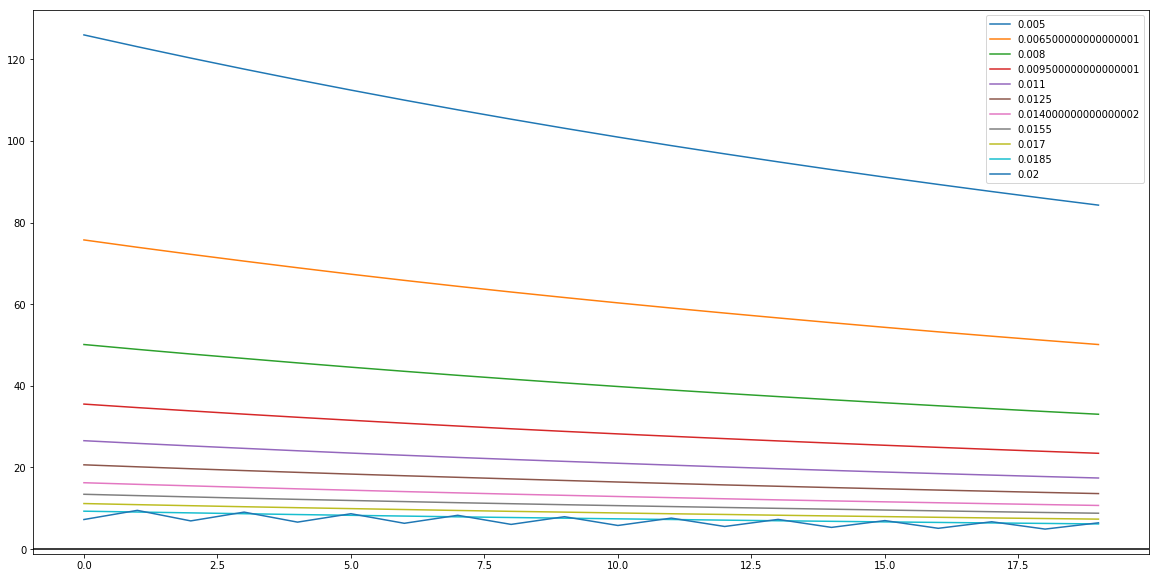

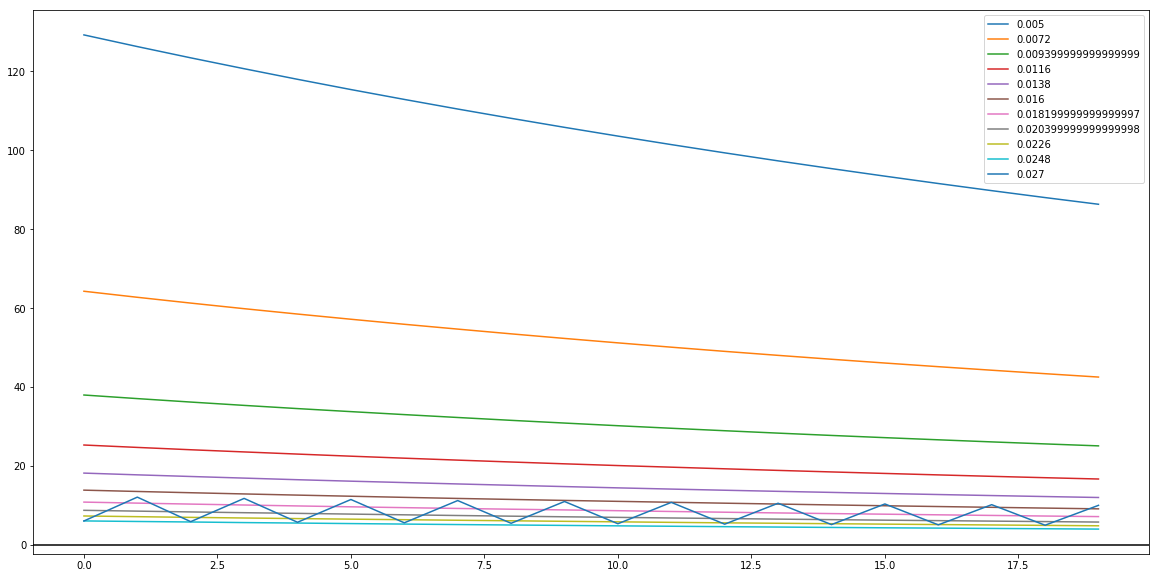

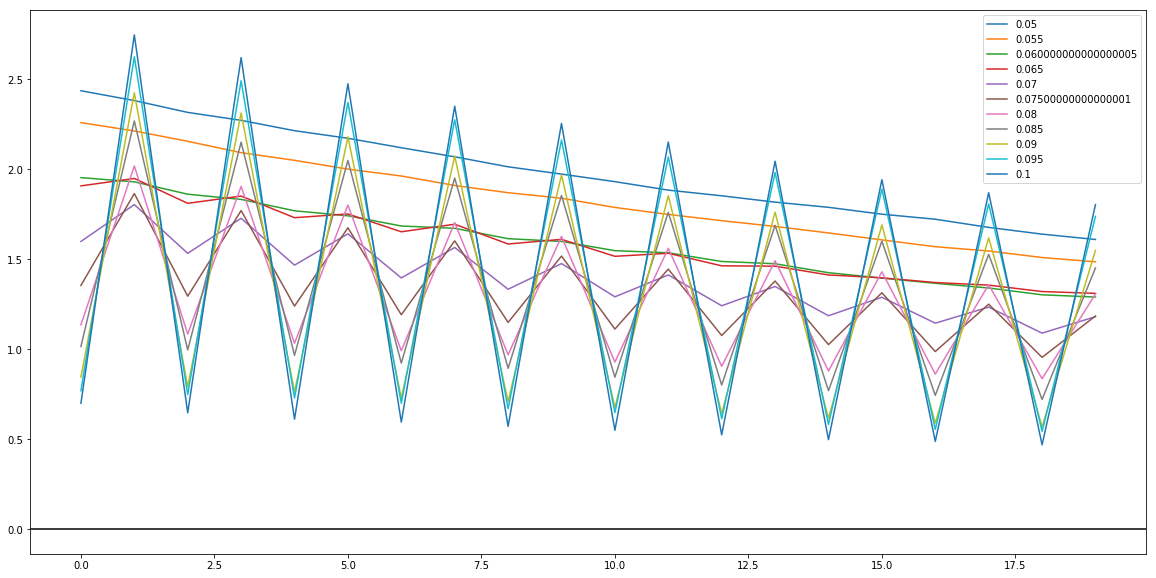

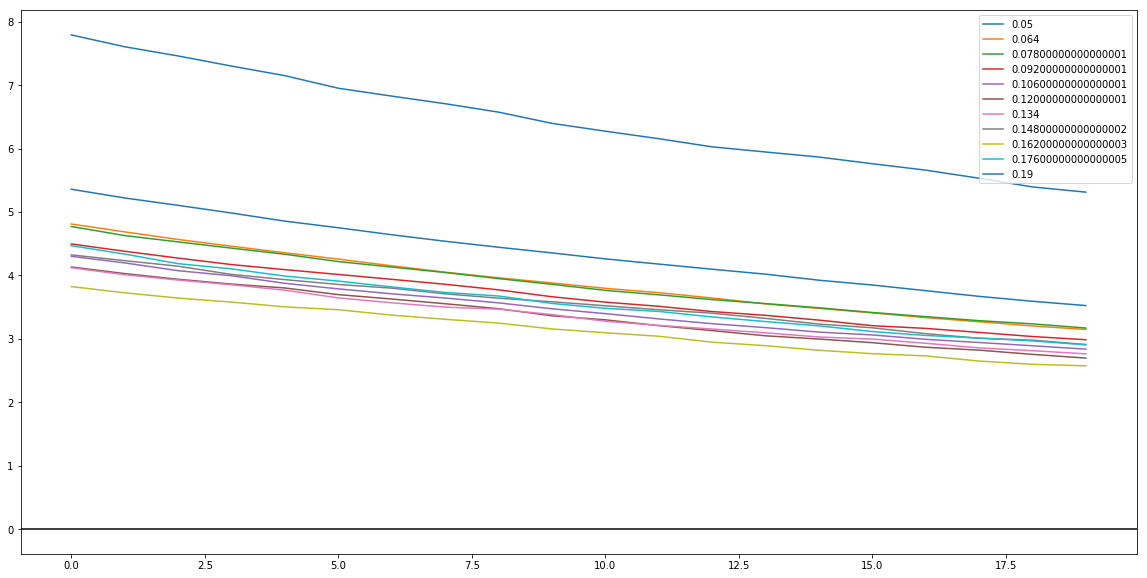

In [237]:
R = 100
M = 10
K = 10

grid = np.linspace(0.05,0.1,11)

plt.figure(figsize=(20,10))
q = 0
for eta in np.linspace(0.005,0.02,11):
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

plt.figure(figsize=(20,10))
q = .25
for eta in np.linspace(0.005,0.027,11):
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

plt.figure(figsize=(20,10))
q = .5
for eta in np.linspace(0.05,0.1,11):
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()



plt.figure(figsize=(20,10))
q = 1
for eta in np.linspace(0.05,0.19,11):
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

In [193]:
class Optimizer:
    def __init__(self, M, K, q, eps, grid):
        self._M = M
        self._K = K
        self._q = q
        self._eps = eps
        self._grid = grid
    
    def count_rounds(self, eta):
        
        # Initialize to zero
        w0 = np.zeros(3)
        ws = [w0]

        losses = []

        loss = fun(w0)
        losses.append(loss)

        # Execute R outer iterations
        while losses[-1] > self._eps:
            if len(losses) > 1000:
                return len(losses) - 1
            w_cur = ws[-1]

            # Generate M random machines to perform the Local SGD steps
            inner_results = [
                Machine(data_count=self._K).execute_inner_sgd(self._q*eta, w_cur)
            for _ in range(self._M)]

            # Perform the outer gradient step
            w_next = w_cur - eta/self._M * np.sum(inner_results, axis=0)
            ws.append(w_next)

            # Record progress on the objective
            w_mean = np.mean(ws, axis=0)
            losses.append(fun(w_mean))
        
        #plt.figure(figsize=(20,10))
        #plt.plot(losses)
        
        return len(losses) - 1
    
    def tune(self, n):
        p = len(self._grid)
        results = np.zeros((n,p))
        for i in range(n):
            for j in range(p):
                eta = self._grid[j]
                results[i][j] = self.count_rounds(eta)
        means = np.mean(results, axis=0)
        idx = np.argmin(means)
        print(f'idx: {idx+1}/{p}')
        
        self._optimal_step = self._grid[idx]
    
    def test(self, n):
        self._avg_rounds = np.mean([self.count_rounds(self._optimal_step) for _ in range(n)])
        return self._avg_rounds

In [147]:
opt = Optimizer(10,10,1,1,np.linspace(.1,.2,11))
opt.tune(10)
opt.test(10)

(11,)
3


166.3

In [146]:
opt = Optimizer(10,10,0.5,1,np.linspace(.25,.35,11))
opt.tune(10)
opt.test(10)

(11,)
5


26.0

(1,)
0


25.8

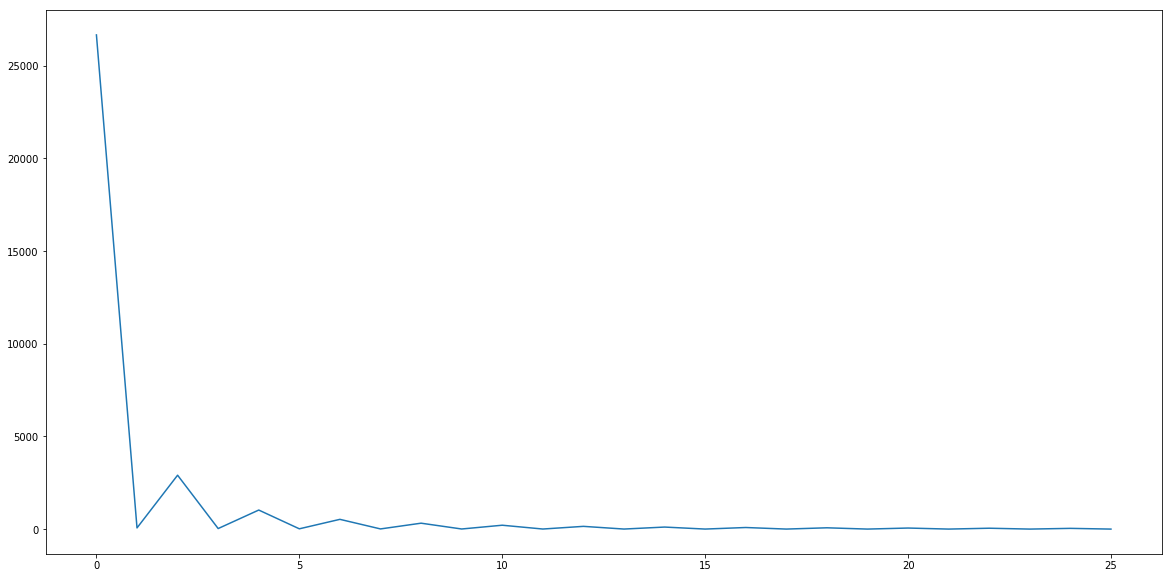

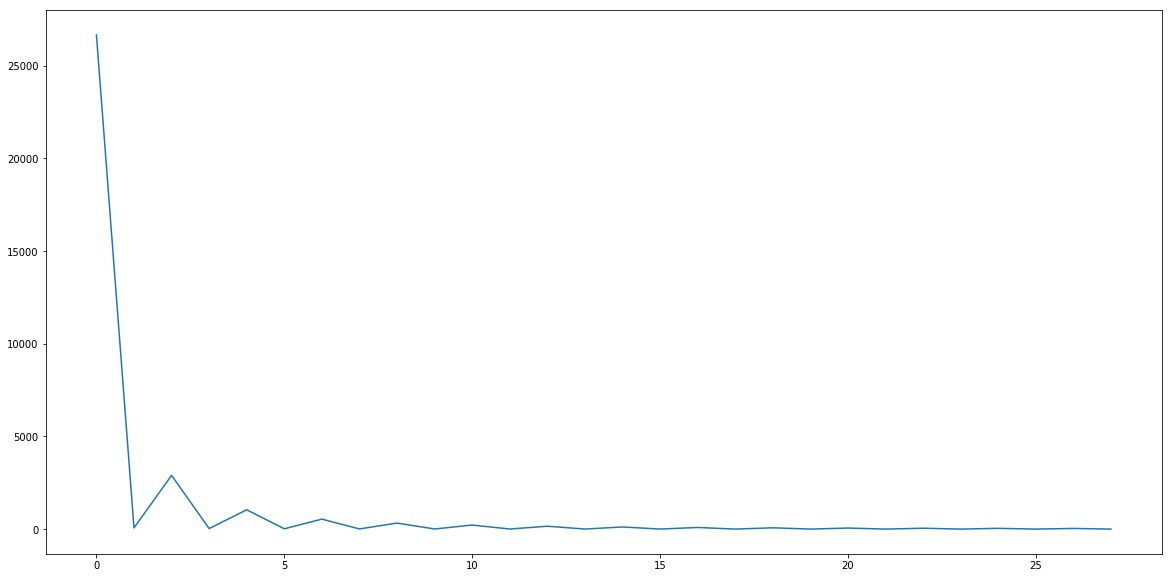

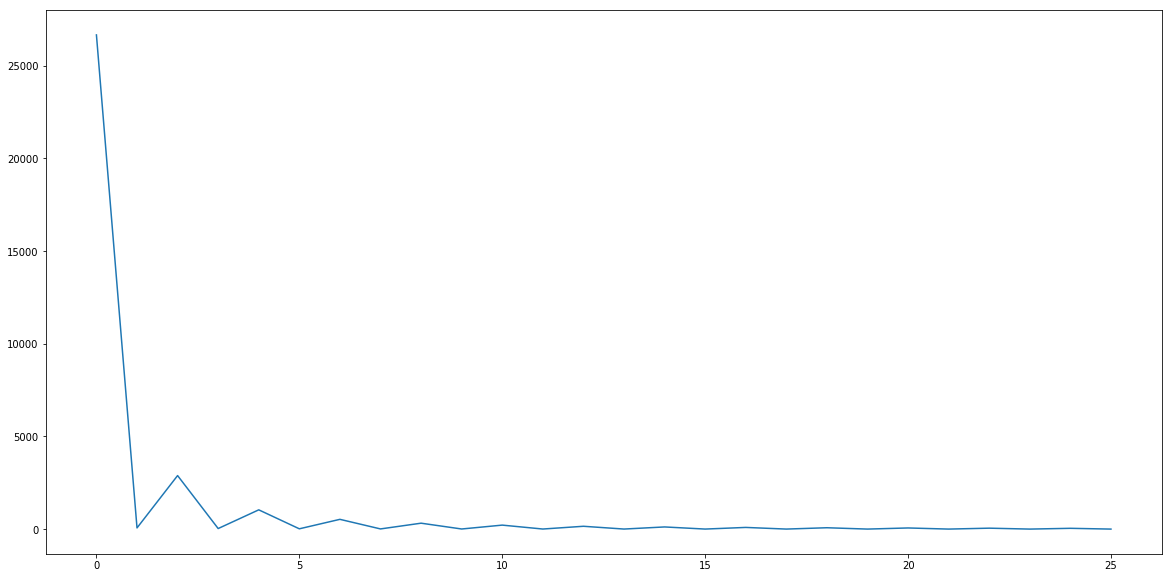

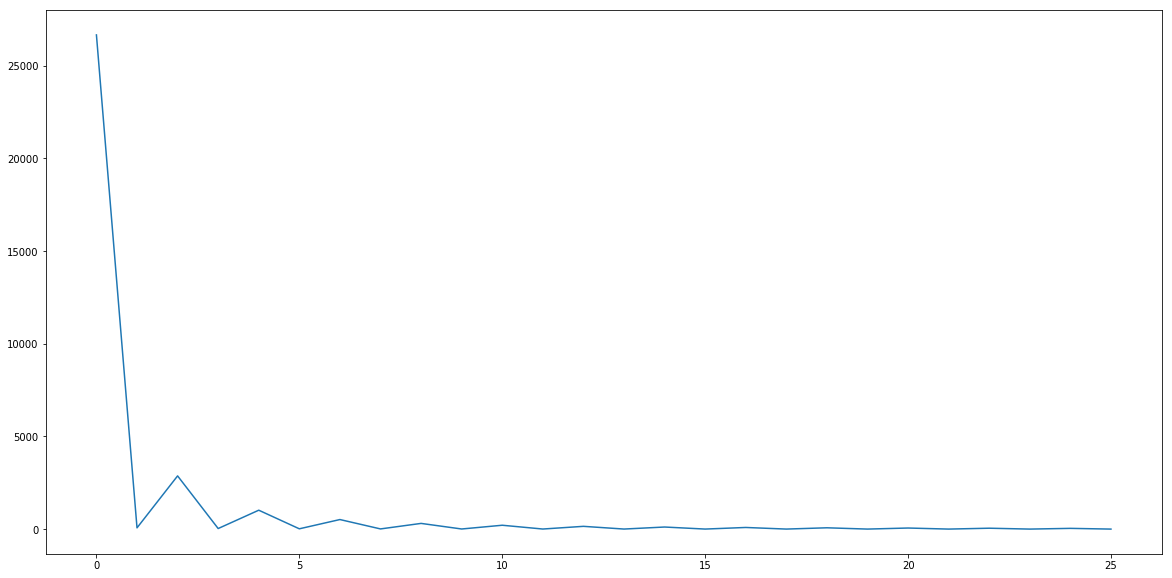

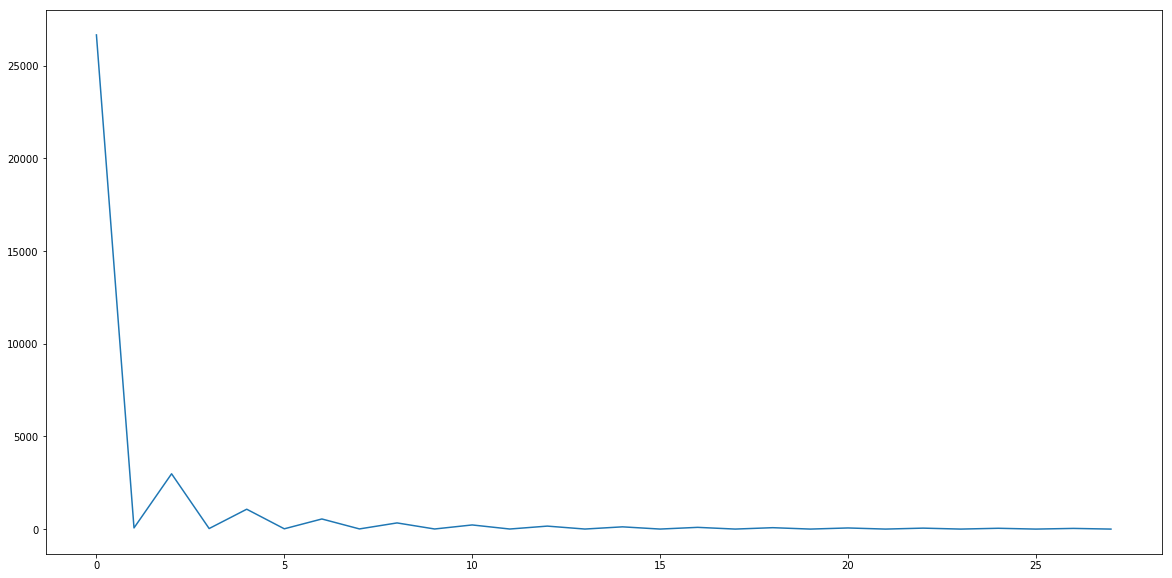

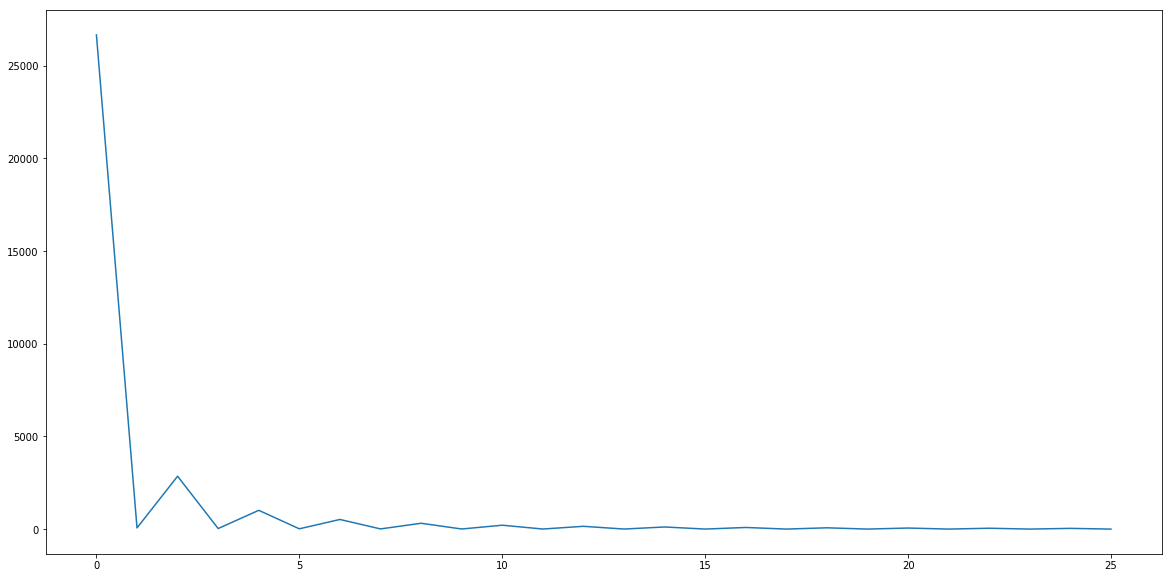

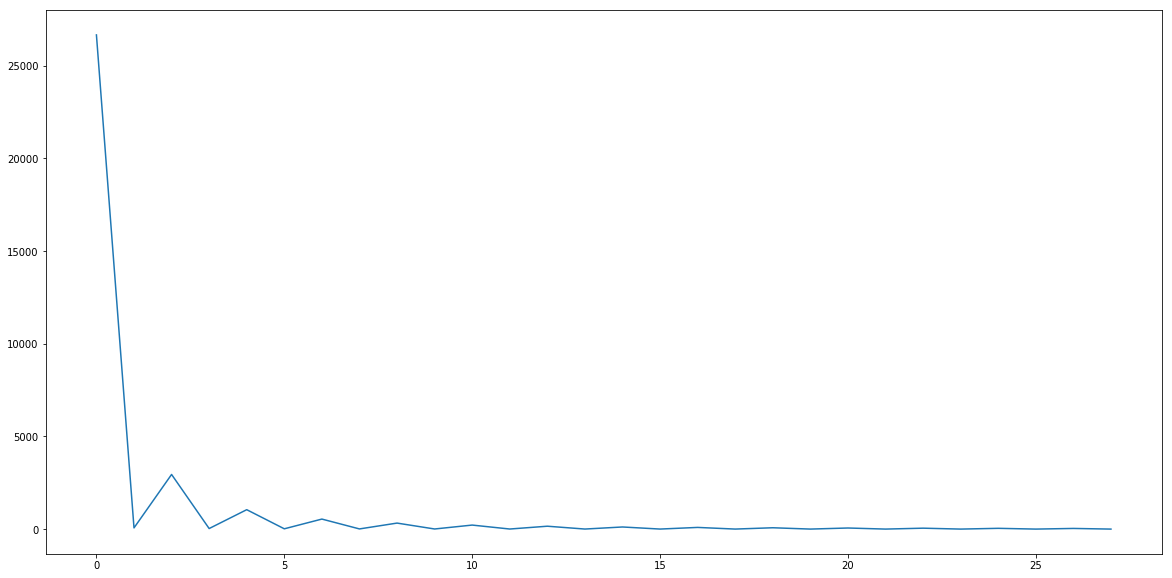

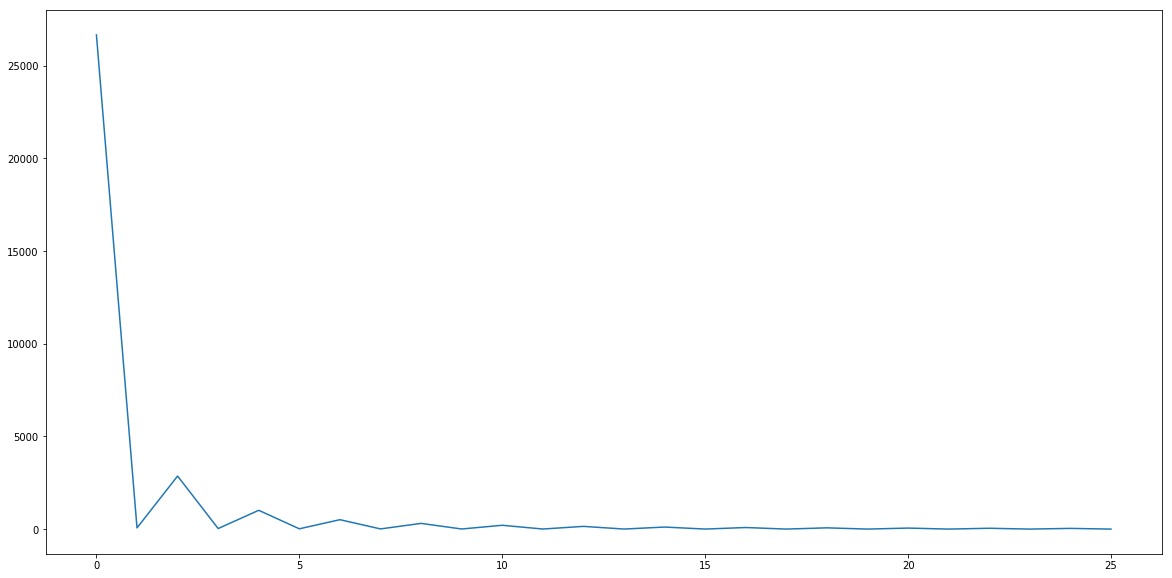

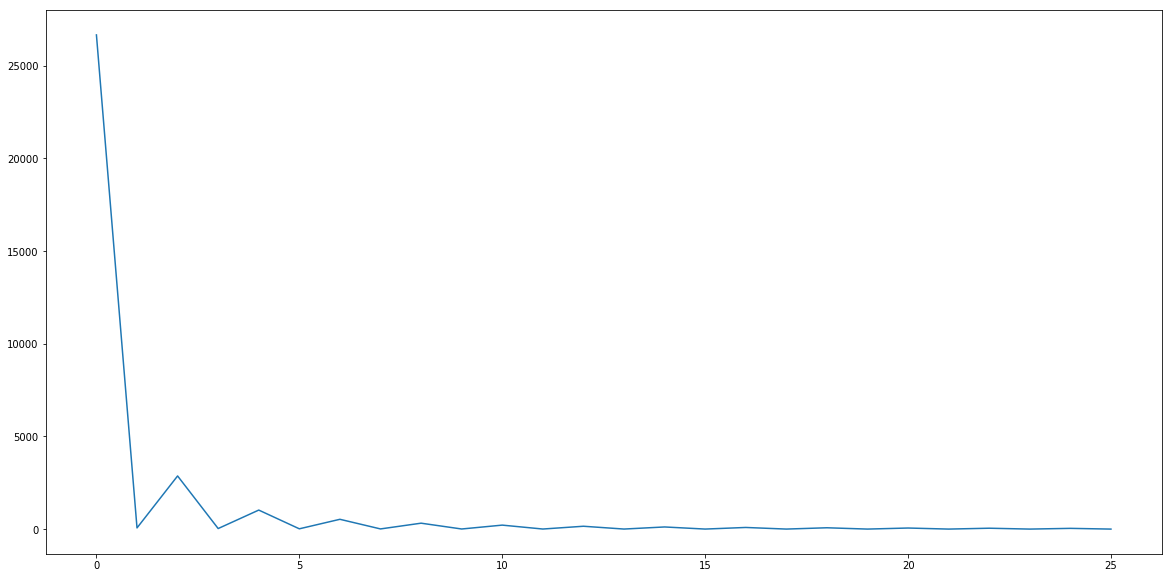

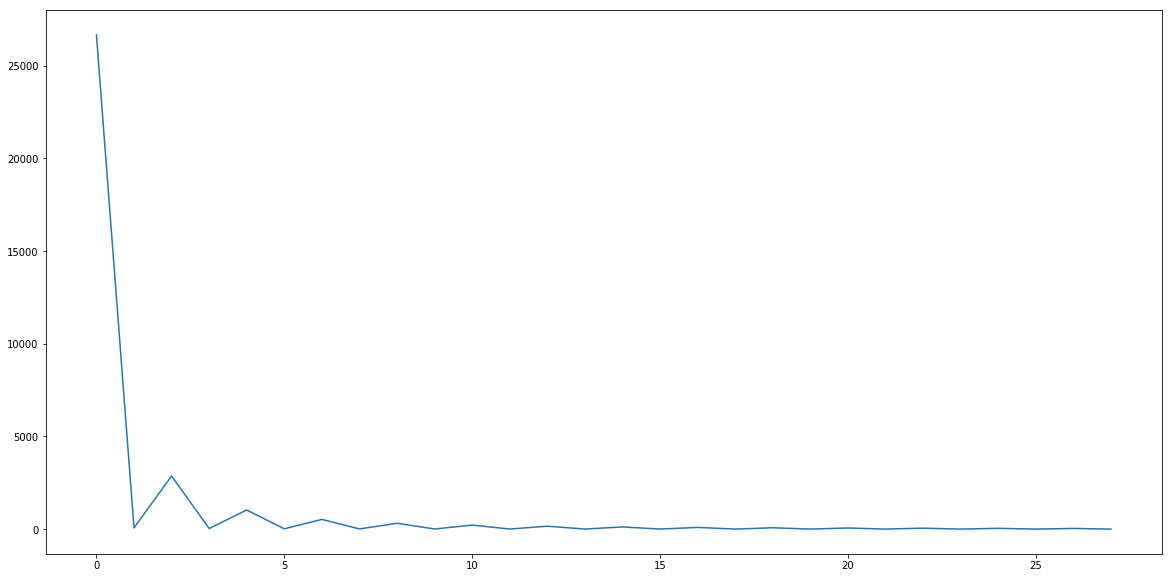

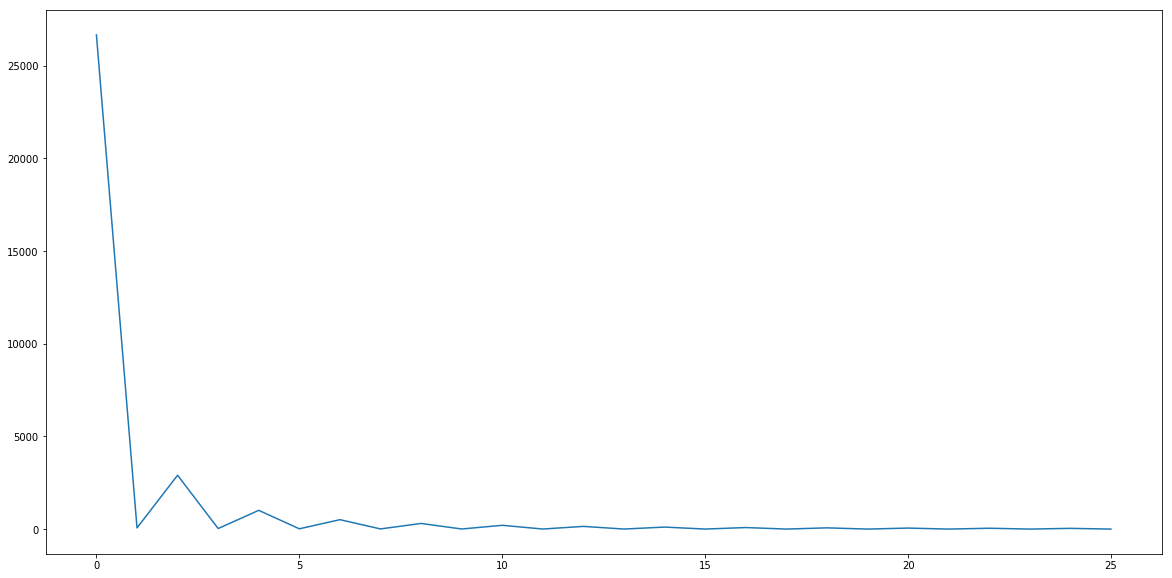

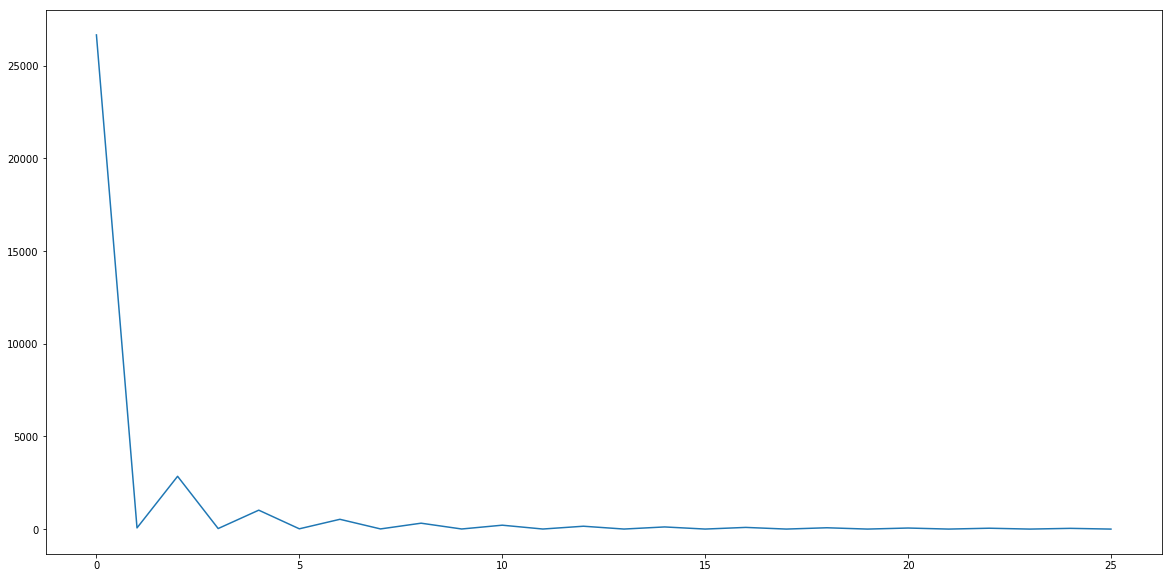

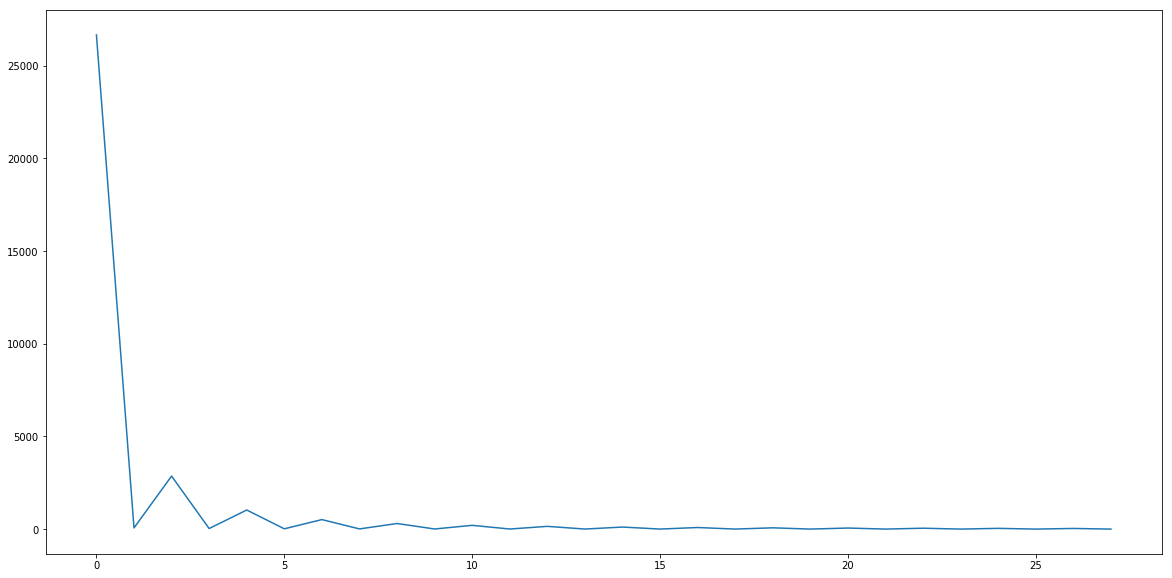

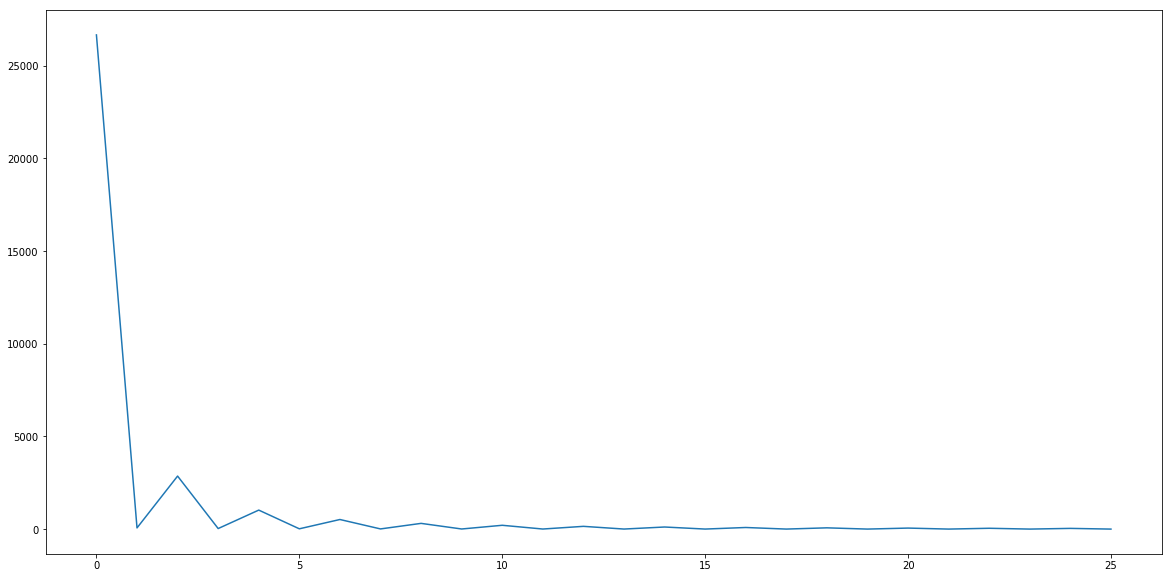

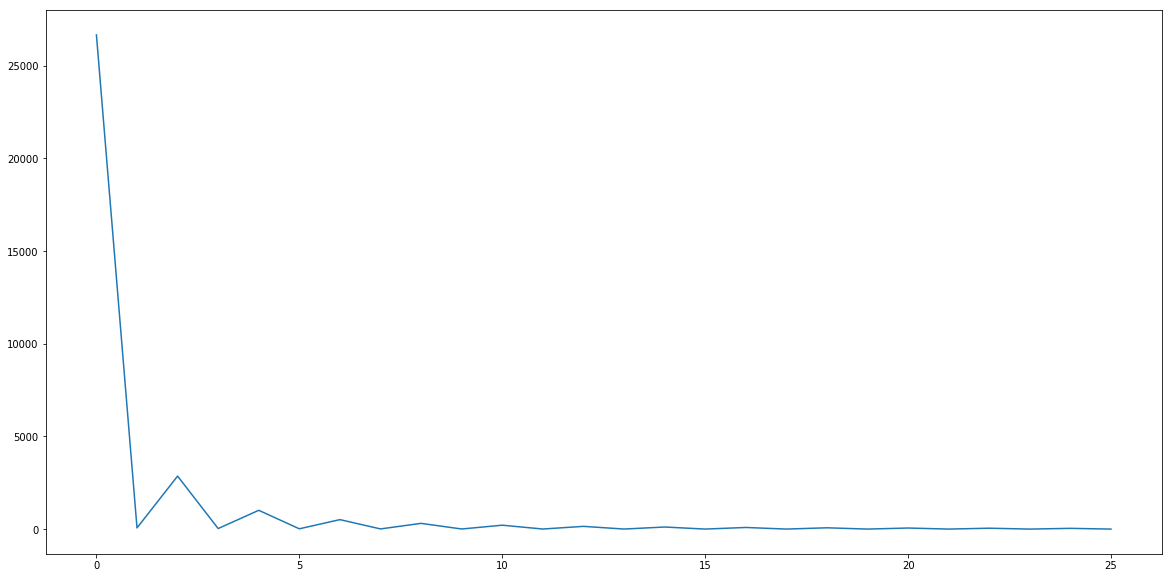

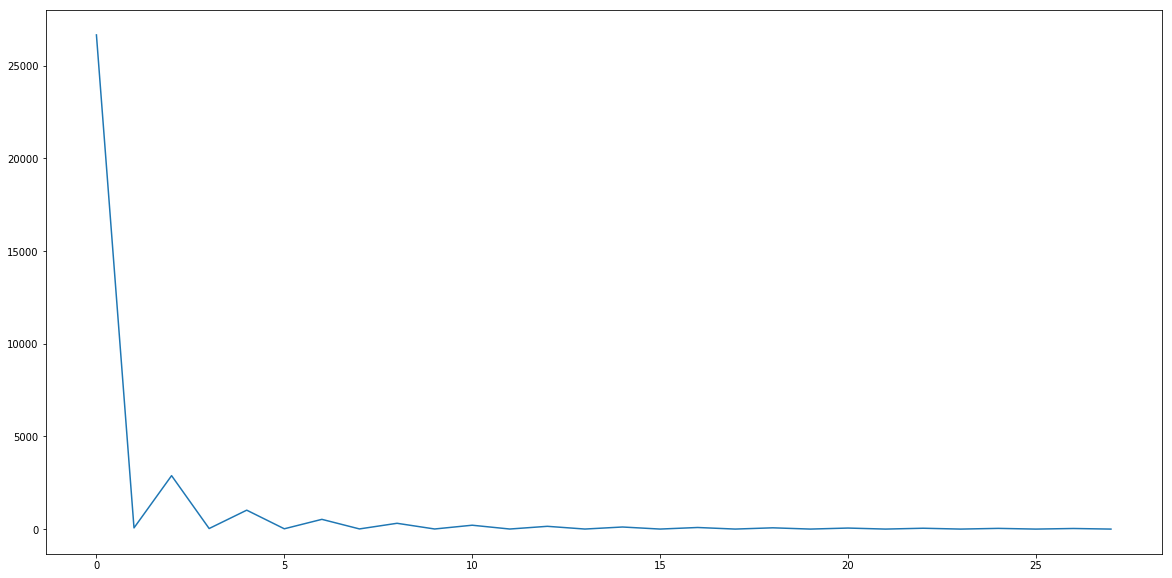

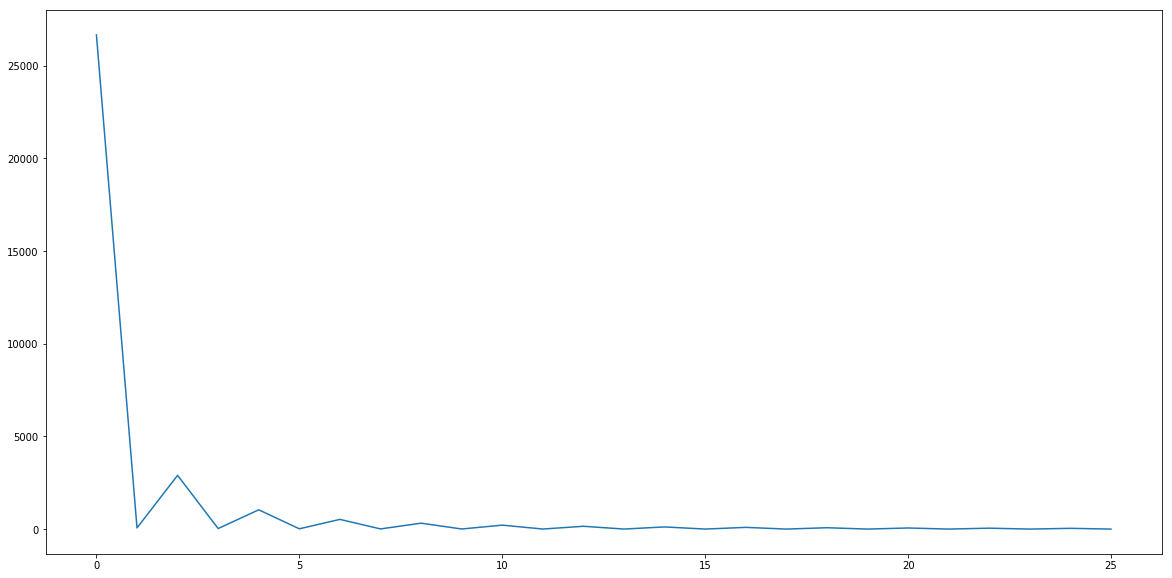

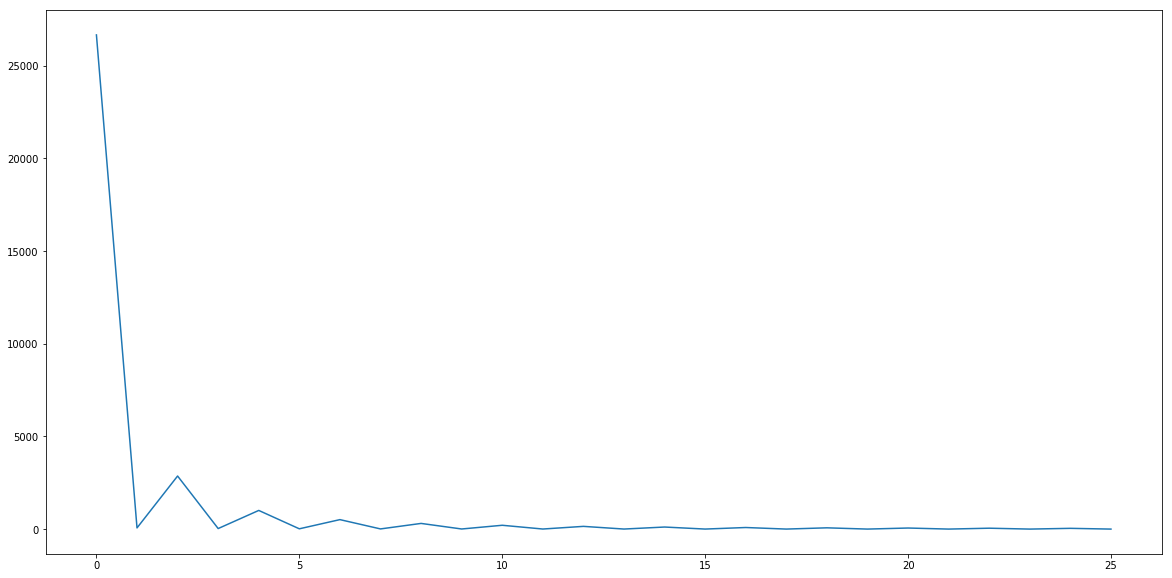

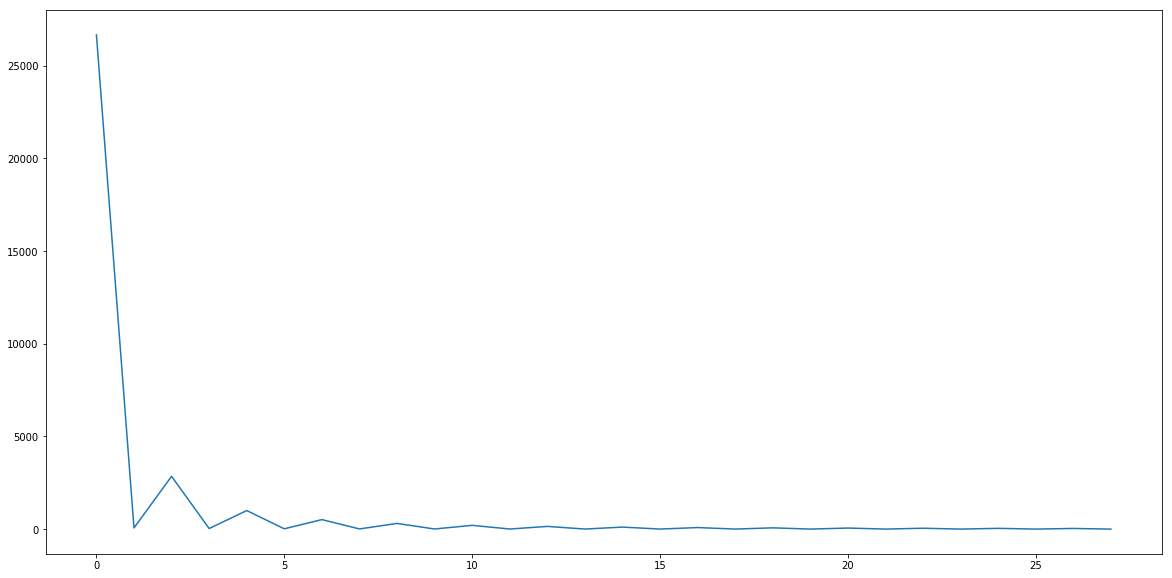

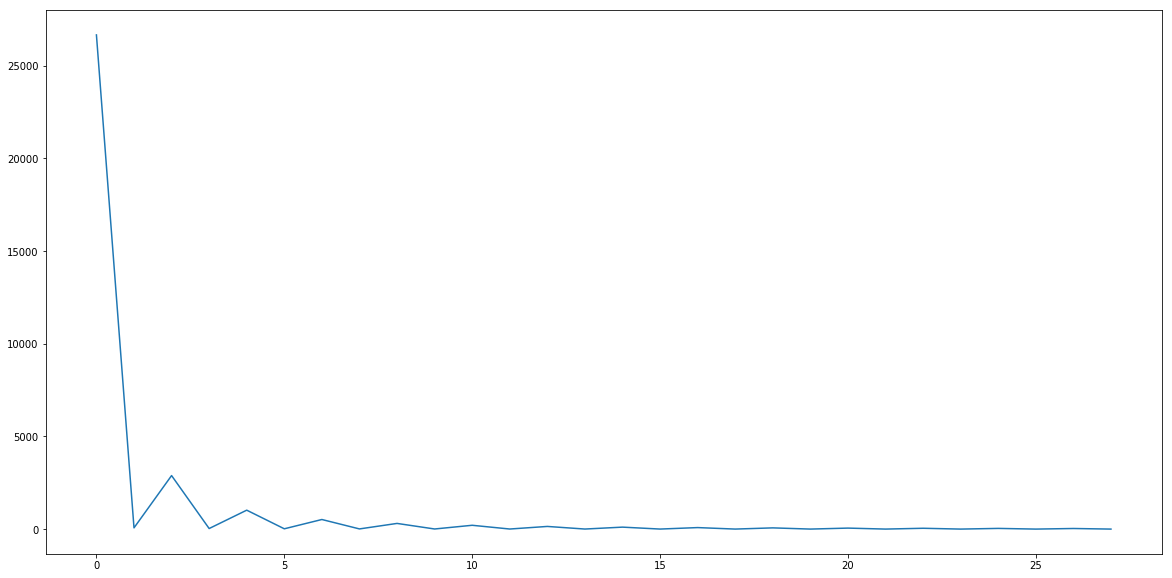

In [175]:
opt = Optimizer(10,10,.5,1,np.linspace(.3,.3,1))
opt.tune(10)
opt.test(10)

In [130]:
opt = Optimizer(10,10,0,1,np.linspace(.1,.13,3))
opt.tune(3)
opt.test(3)

/Users/geoffreywest/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
/Users/geoffreywest/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/Users/geoffreywest/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/geoffreywest/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


(3,)
2


294.0

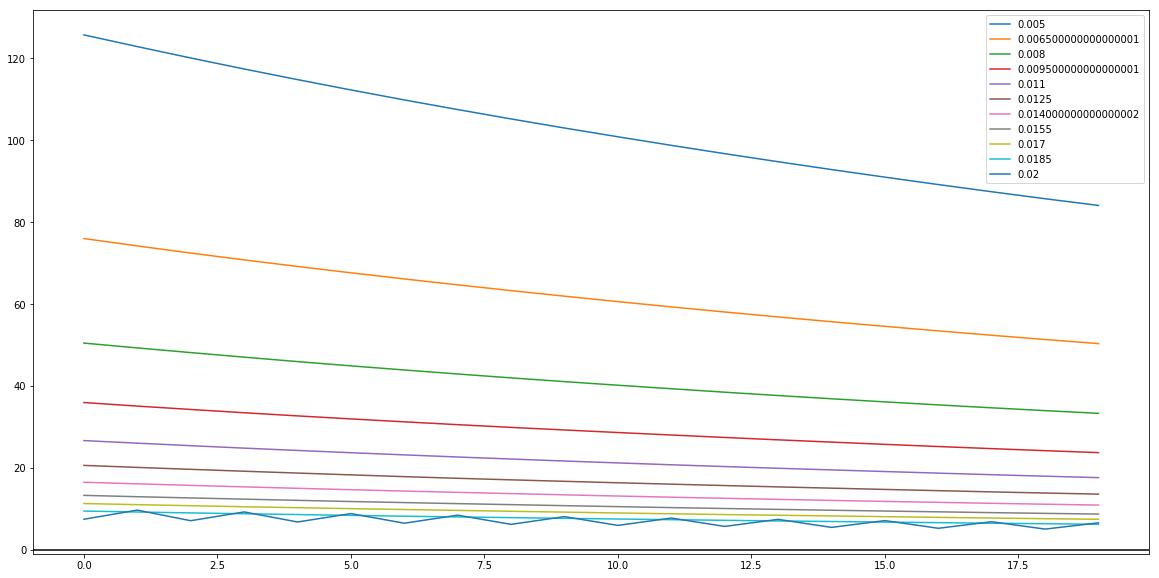

In [207]:
R = 100
M = 10
K = 10

grid = np.linspace(0.005,0.02,11)

plt.figure(figsize=(20,10))
q = 0
for eta in grid:
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

In [209]:
suboptimalities = 1 / np.arange(1,11)

In [210]:
num_rounds_dict = {}

In [241]:
M = 10
K = 10
q = 1
grid = np.linspace(0.07,0.17,11)

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

idx: 8/11
nr: 168.7

idx: 10/11
nr: 241.3

idx: 10/11
nr: 284.4

idx: 8/11
nr: 334.2

idx: 11/11
nr: 373.5

idx: 8/11
nr: 417.8

idx: 9/11
nr: 428.3

idx: 10/11
nr: 466.6

idx: 10/11
nr: 489.1

idx: 11/11
nr: 520.6



In [240]:
M = 10
K = 10
q = .5
grid = np.linspace(0.06,0.1,11)

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

idx: 11/11
nr: 70.8

idx: 11/11
nr: 100.8

idx: 11/11
nr: 121.6

idx: 11/11
nr: 142.0

idx: 11/11
nr: 162.8

idx: 11/11
nr: 180.6

idx: 11/11
nr: 193.2

idx: 11/11
nr: 208.4

idx: 11/11
nr: 231.2

idx: 11/11
nr: 232.4



In [239]:
M = 10
K = 10
q = .25
grid = np.linspace(0.015,0.027,11)

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

idx: 10/11
nr: 192.7

idx: 10/11
nr: 272.7

idx: 10/11
nr: 335.9

idx: 10/11
nr: 383.7

idx: 10/11
nr: 434.8

idx: 10/11
nr: 471.8

idx: 10/11
nr: 510.6

idx: 10/11
nr: 544.8

idx: 10/11
nr: 580.7

idx: 10/11
nr: 612.1



In [238]:
M = 10
K = 10
q = 0
grid = np.linspace(0.015,0.02,11)

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

idx: 11/11
nr: 224.8

idx: 11/11
nr: 315.4

idx: 11/11
nr: 388.8

idx: 11/11
nr: 448.2

idx: 11/11
nr: 499.2

idx: 11/11
nr: 545.4

idx: 11/11
nr: 591.4

idx: 11/11
nr: 630.8

idx: 11/11
nr: 668.6

idx: 11/11
nr: 714.4



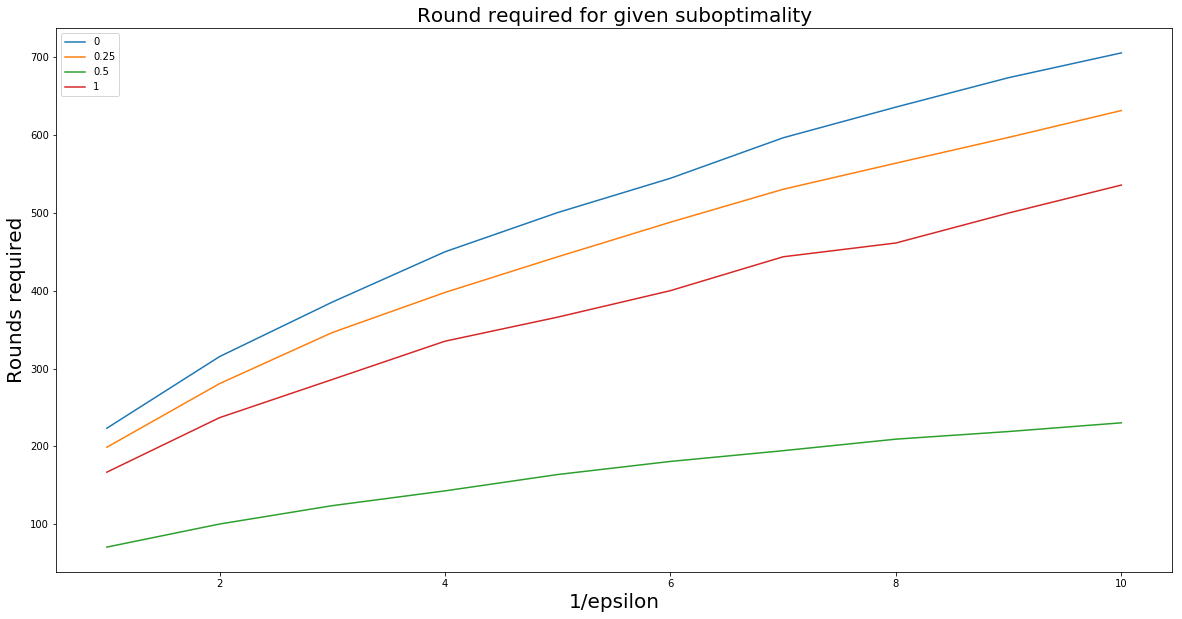

In [223]:
plt.figure(figsize=(20,10))
for m,k,q in sorted(num_rounds_dict.keys()):
    if (m,k) == (10,10):
        plt.plot(1/suboptimalities, num_rounds_dict[m,k,q], label=q)
plt.legend()
plt.xlabel('1/epsilon', fontsize=20)
plt.ylabel('Rounds required', fontsize=20)
plt.title('Round required for given suboptimality', fontsize=20)
plt.show()

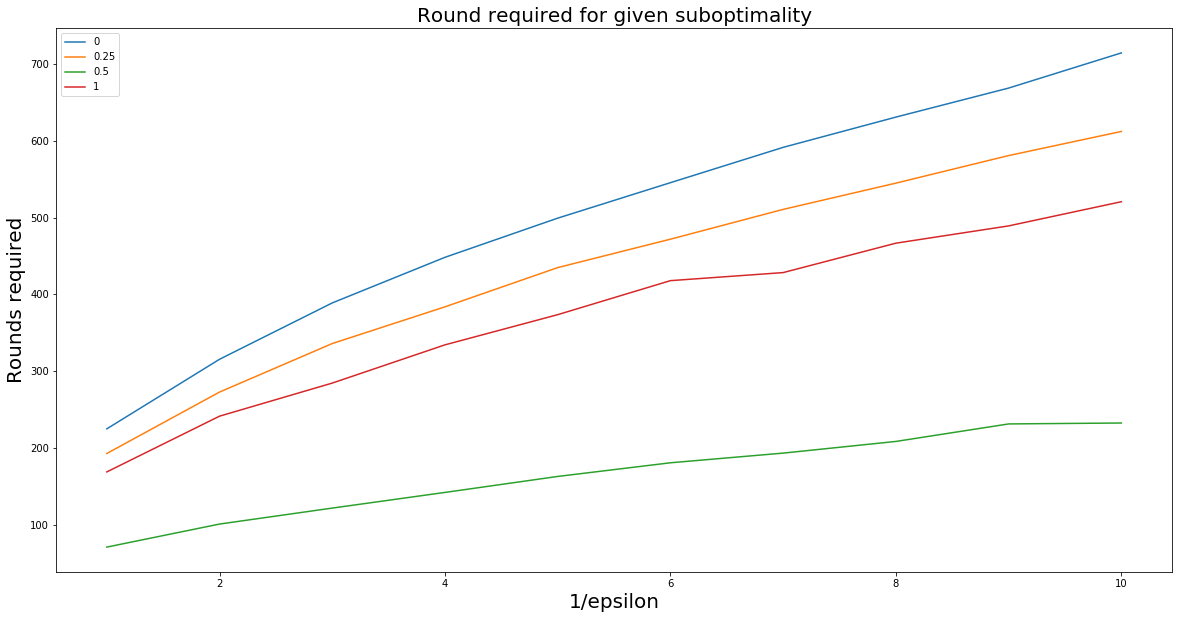

In [242]:
plt.figure(figsize=(20,10))
for m,k,q in sorted(num_rounds_dict.keys()):
    if (m,k) == (10,10):
        plt.plot(1/suboptimalities, num_rounds_dict[m,k,q], label=q)
plt.legend()
plt.xlabel('1/epsilon', fontsize=20)
plt.ylabel('Rounds required', fontsize=20)
plt.title('Round required for given suboptimality', fontsize=20)
plt.show()

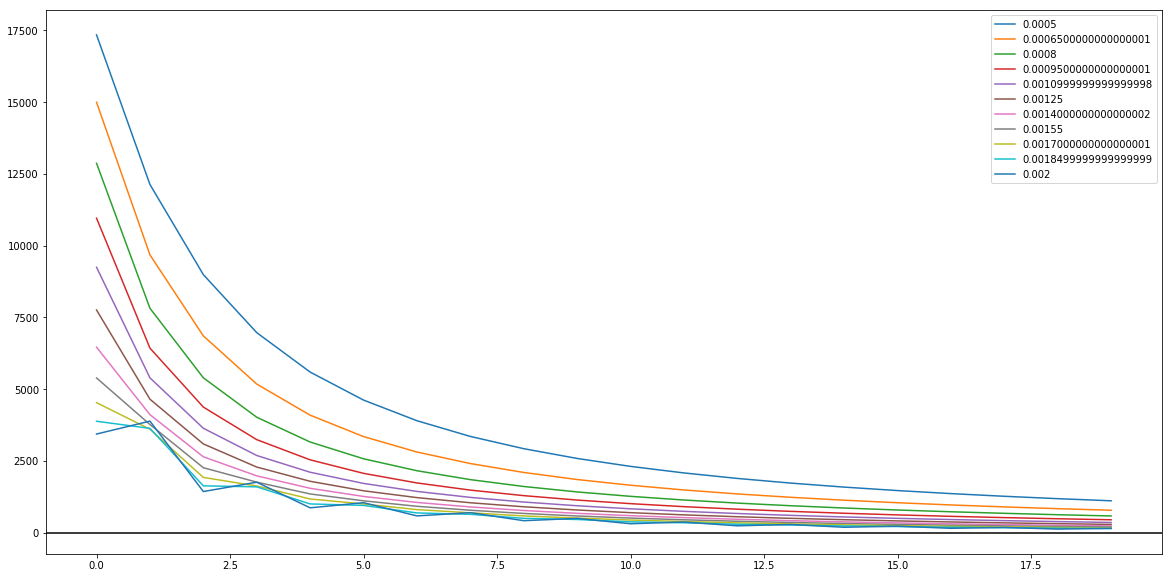

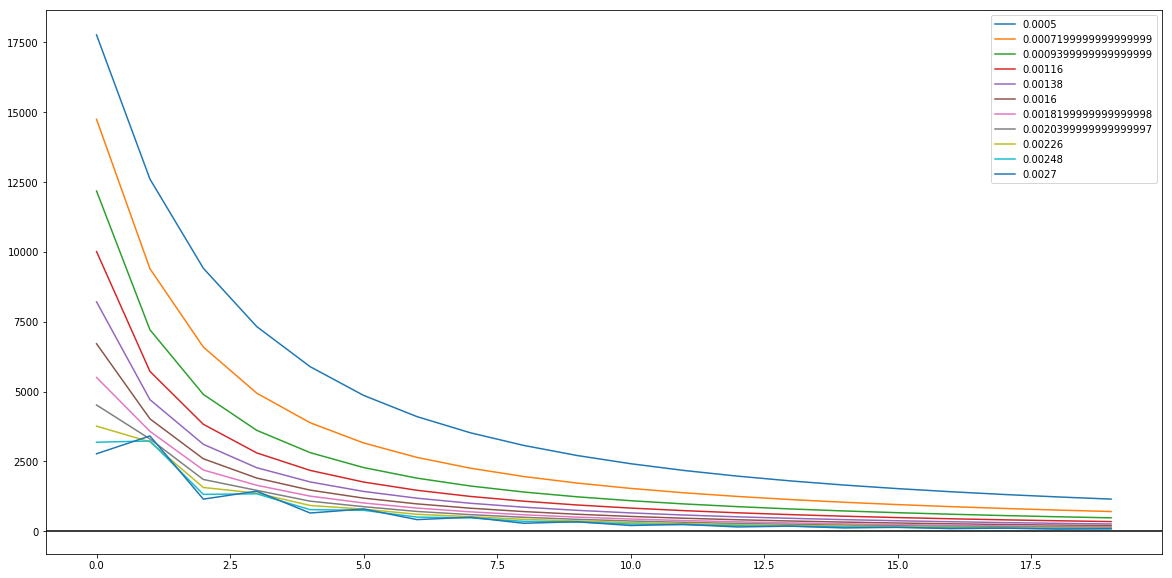

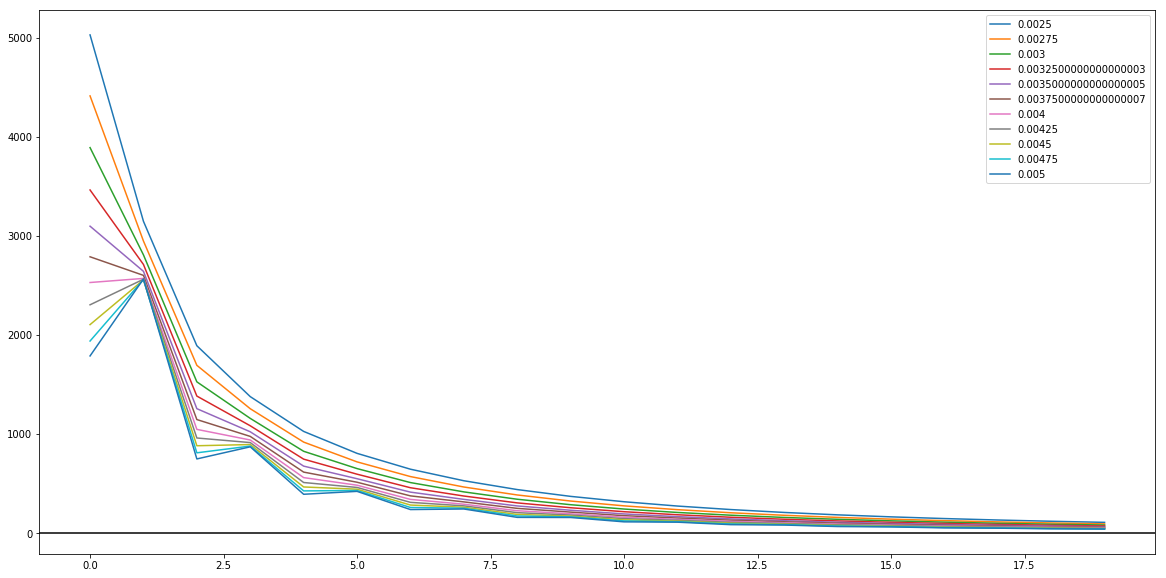

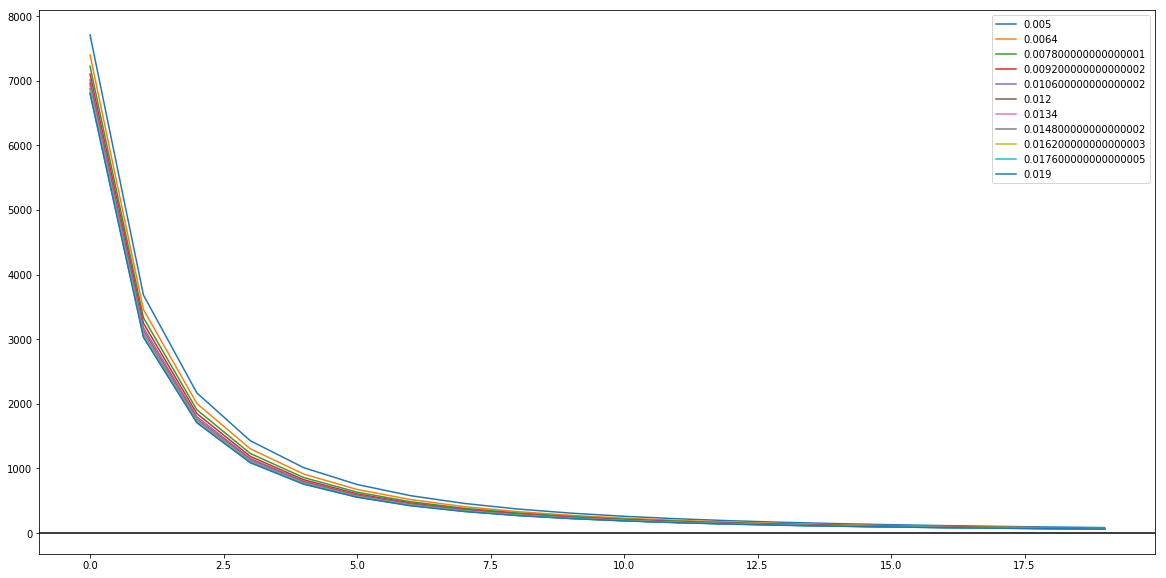

In [244]:
R = 20
M = 10
K = 100

grid = np.linspace(0.05,0.1,11)

plt.figure(figsize=(20,10))
q = 0
for eta in np.linspace(0.005,0.02,11) / 10:
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

plt.figure(figsize=(20,10))
q = .25
for eta in np.linspace(0.005,0.027,11) / 10:
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

plt.figure(figsize=(20,10))
q = .5
for eta in np.linspace(0.05,0.1,11) / 20:
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()



plt.figure(figsize=(20,10))
q = 1
for eta in np.linspace(0.05,0.19,11) / 10:
    losses, _, _ = experiment_method_1(R,M,K,q*eta,eta)
    plt.plot(losses[-20:], label=eta)
    plt.legend()
plt.axhline(0, color='black')
plt.show()

In [246]:
M = 10
K = 100
q = 1
grid = np.linspace(0.07,0.17,11) / 10

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

idx: 11/11
nr: 340.0

idx: 11/11
nr: 477.4

idx: 11/11
nr: 585.5

idx: 11/11
nr: 674.9

idx: 11/11
nr: 757.0



KeyboardInterrupt: 

In [ ]:
M = 10
K = 100
q = .5
grid = np.linspace(0.06,0.1,11) / 15

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

In [ ]:
M = 10
K = 100
q = .25
grid = np.linspace(0.015,0.027,11) / 10

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds

In [ ]:
M = 10
K = 100
q = 0
grid = np.linspace(0.015,0.02,11) / 10

num_rounds = []
for eps in suboptimalities:
    opt = Optimizer(10,10,q,eps,grid)
    opt.tune(10)
    nr = opt.test(10)
    print(f'nr: {nr}\n')
    num_rounds.append(nr)
num_rounds_dict[M,K,q] = num_rounds